In [58]:
import warnings
# warnings.filterwarnings('ignore')      # never show warnings
warnings.filterwarnings(action='once') # show warnings once and never again

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, TensorBoard

import tensorflow as tf

import pyarrow.parquet as pyparquet
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
tqdm.pandas()
import math
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix

pd.set_option('display.max_colwidth', -1)

# save and load tokenizer
import pickle 
import json

import nltk
from nltk.corpus import stopwords

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Importing the graph_objs module which contains plotting objects
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import matplotlib.pyplot as plt

In [53]:
import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../data/.DS_Store
../data/gfmodel_v4.vec
../data/gfmodel_v4.vec.zip
../data/qc-deletionreason-contactrequest.snappy.parquet
../data/qc-notdeleted.snappy.parquet


### Set Parameters

In [52]:
max_features = 10000

embedding_vecor_length = 300


### Prepare train and test set

In [38]:
posfile = '../data/qc-deletionreason-contactrequest.snappy.parquet'
negfile = '../data/qc-notdeleted.snappy.parquet'

pos = pyparquet.read_table(posfile).to_pandas()[["label", "decoded_title", "decoded_body"]]
neg = pyparquet.read_table(negfile).to_pandas()[["label", "decoded_title", "decoded_body"]]

print("Pos dataset: {}".format(len(pos)))
print("Neg dataset: {}".format(len(neg)))

Pos dataset: 11479
Neg dataset: 831203


In [41]:
# reduce the size of neg and pos to N
N = 10000.0
pos = pos.sample(frac=N/len(pos)).reset_index(drop=True)
neg = neg.sample(frac=N/len(neg)).reset_index(drop=True)

print("Pos dataset: {}".format(len(pos)))
print("Neg dataset: {}".format(len(neg)))

Pos dataset: 10000
Neg dataset: 10000


In [42]:
pos.head()

,label,decoded_title,decoded_body
0,__label__contact-request,einsamkeit ist nicht so schön ?,hallo kann mir eine/er helfen bitte ich bin 12 jahre alt und finde einfach keine freundin ich verbringe echt super gerne zeit mit anderen danke jetzt schonmal für die antworten 😁
1,__label__contact-request,boyaa chips ?,"hallo . zockt jemand auf facebook boyaa deutsch poker ? hat jemand chips für mich zum zocken ? oder gibts vielleicht jemanden , der dort nicht mehr spielt und mir die chips geben würde ? wäre sehr nett ."
2,__label__contact-request,hilfe zur computer auflösung per teamviewer ?,hallo zusammen ich habe probleme mit meiner computer auflösung . ich möchte sie ändern weiß aber nicht mehr wo ich das tun kann . bzw . da wo ich es normalerweise mache finde ich es nicht mehr . kann mir jemand per teamviewer helfen ? würde dann kurz die daten durchgeben . danke ! jan
3,__label__contact-request,ich brauche bitte unterstützung in excel ( geschachtelte wenn- funktion ?,"am montag schreiben wir eine klasur darüber , und ich muss einmal die lösungen haben <strong> damit ich das prinzip verstehe </strong> ich kenne keinen excel nachhilfe lehrer , ich bräuchte jemand der mir die aufgaben macht , weil <strong> ich das wirklich verstehen will </strong> . wenn jemand <strong> wirklich helfen will </strong> dann soller mir hier per gutefrage mir privat schreiben damit ich ihm die excel dateien mit den aufgaben von geschachtelte wenn funktion per email schicke damit er mir das macht und ich es endlich verstehe . ich bitte um verständnis und keine vulgäre antworten , ich bei der typische , der mit den lösungen am besten lernt oder nachhilfe ( problem hier ist dass ich keine excel nachhilfe kenne )"
4,__label__contact-request,rap textschreiber ?,hallo ich suche wen der für mich raptexte schreibt . würde diese nicht veröffentlichen . einfach in die kommentare rein thema egal


In [43]:
neg.head()

,label,decoded_title,decoded_body
0,__label__legit,nmd r1 rechtzeitig ?,"guten abend gutefrage . net . ich suche für meine abschlussfeier ein paar schuhe von adidas , am liebsten die nmd r1 in einer schwarzen farbe . ich hab mich auf internetseiten mal umgeguckt aber die schuhe gibt es entweder nicht in meiner größe , in einer schwarzen farbe oder sie kommen nicht mehr rechtzeitig zur abschlussfeier an . ich möchte wissen ob mir jemand eine seite geben kann , wo ich die noch rechtzeitig bestellen kann . meine schuhgröße : 45 bevorzugte farben : schwarz mit schwarzer sohle abschlussfeier : am 14_06_2019 danke für die hilfe der helfenden 😃"
1,__label__legit,auto geliehen ?,"ich habe einen ehemaligen "" kollegen "" mein autoschlüssel geliehen da er angeblich zwei mädels hätte die vorbei kommen wollten und eine davon einen führerschein hätte und sie mich dann nach der arbeit abholen würden . jedoch hat das aloch mich verascht und er ist mit meinem auto spurlos verschwunden gewesen . ich habe dann gegen mitternacht anzeige erstattet dass mein auto geklaut wurde aber ich habe seinen namen nicht erwähnt . am nächsten tag hat er sich gemeldet und mir gesagt dass er von der polizei angehalten worden ist und das auto beschlagnahmt ist . ich habe übermorgen jetzt ein gerichtstermin als zeuge und will mich natürlich nicht selber belasten was kann ich am besten sagen ? immerhin habe ich keine beweise dass die story mit den mädels stimmt und ich weiß genau das er im gericht erwähnen wird das ich ihm die schlüssel ausgehändigt habe und er das auto nicht gestohlen hat . kann mir der führerschein entzogen werden ?"
2,__label__legit,zu dünn oder attraktiv ?,"<x-gf-img-placeholder data-image-id= "" 11930001 "" > </x-gf-img-placeholder> <x-gf-img-placeholder data-image-id= "" 11929996 "" > </x-gf-img-placeholder>"
3,__label__legit,was ist genau der unterschied zwischen einer depression und einem burnout ?,
4,__label__legit,"was haltet ihr von diesem "" schriftzug "" an meinem eingang ?","sihe bild ! <x-gf-img-placeholder data-image-id= "" 12311312 "" > </x-gf-img-placeholder>"


In [44]:
neg_train, neg_test = train_test_split(neg, test_size=0.2)
pos_train, pos_test = train_test_split(pos, test_size=0.2)

# # upsample legit questions in training dataset
# legit_train = pd.concat([legit_train]*2, ignore_index=True) # Ignores the index

print("Training dataset pos: {}".format(len(pos_train)))
print("Testing dataset pos: {}".format(len(pos_test)))
print("Training dataset neg: {}".format(len(neg_train)))
print("Testing dataset neg: {}".format(len(neg_test)))

# concatinate adult and legit and shuffle the resulting test and train sets
train = pd.concat([pos_train, neg_train]).sample(frac=1).reset_index(drop=True)
test = pd.concat([pos_test, neg_test]).sample(frac=1).reset_index(drop=True)

print("Training dataset: {}".format(len(train)))
print("Testing dataset: {}".format(len(test)))

print("Pos dataset: {}".format(len(pos)))
print("Neg dataset: {}".format(len(neg)))

Training dataset pos: 8000
Testing dataset pos: 2000
Training dataset neg: 8000
Testing dataset neg: 2000
Training dataset: 16000
Testing dataset: 4000
Pos dataset: 10000
Neg dataset: 10000


In [45]:
train['question_text'] = train['decoded_title'].map(str) + " " + train['decoded_body'].map(str)
test['question_text'] = test['decoded_title'].map(str) + " " + test['decoded_body'].map(str)


In [46]:
train.question_text.str.split().str.len().describe()

count    16000.000000
mean     62.394125   
std      65.918855   
min      3.000000    
25%      24.000000   
50%      43.000000   
75%      76.000000   
max      678.000000  
Name: question_text, dtype: float64

In [47]:
test.question_text.str.split().str.len().describe()

count    4000.00000 
mean     68.72100   
std      208.38801  
min      4.00000    
25%      25.00000   
50%      44.00000   
75%      79.00000   
max      12302.00000
Name: question_text, dtype: float64

- set maxlen parameter

In [48]:
maxlen = 100

In [49]:
## fill up the missing values
train_X = train["question_text"].fillna("_na_").values
test_X = test["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='', lower=False)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, padding='post', truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, padding='post', truncating='post')

train["target"] = ["0" if x =="__label__legit" else "1" for x in train["label"]]
test["target"] = ["0" if x =="__label__legit" else "1" for x in test["label"]]

test_y = test['target']
train_y = train['target']

### Load embedding

In [54]:
# comment it because of lower word coverage (v4)
# EMBEDDING_FILE = '../input/gf-embeddings-v2/gfmodel_v6.vec' --> memory error
EMBEDDING_FILE = '../data/gfmodel_v4.vec'

embeddings_index = {}
f = open(EMBEDDING_FILE)
for line in tqdm(f):
    values = line.split(" ")
    if len(values) == 302:
        word = values[0]
        coefs = np.asarray(values[1:301], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

735284it [00:53, 13771.23it/s]

Found 735283 word vectors.


In [55]:
## embedding setup

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

/Users/agnes.ferenczi/.pyenv/versions/3.6.7/envs/qc-contactrequest/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



### Model

![](http://)- number of memory cells set to less than 80-400 based on ([link](https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm))

In [56]:
# create the model
from keras.callbacks import EarlyStopping

def model_init():
    model = Sequential()
    model.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen,  weights=[embedding_matrix]))
    model.add(Dropout(0.8))
    model.add(LSTM(100))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [64]:
model = model_init()
tensorboard_callback = TensorBoard("logs")
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), tensorboard_callback])

Train on 14400 samples, validate on 1600 samples
Epoch 1/10
14400/14400 [==============================] - 36s 2ms/step - loss: 0.6774 - acc: 0.5847 - val_loss: 0.6423 - val_acc: 0.6169
Epoch 2/10
14400/14400 [==============================] - 33s 2ms/step - loss: 0.5655 - acc: 0.7217 - val_loss: 0.3893 - val_acc: 0.8581
Epoch 3/10
14400/14400 [==============================] - 33s 2ms/step - loss: 0.3764 - acc: 0.8688 - val_loss: 0.3749 - val_acc: 0.8762
Epoch 4/10
14400/14400 [==============================] - 33s 2ms/step - loss: 0.3305 - acc: 0.8824 - val_loss: 0.2826 - val_acc: 0.8919
Epoch 5/10
14400/14400 [==============================] - 32s 2ms/step - loss: 0.2814 - acc: 0.8998 - val_loss: 0.2974 - val_acc: 0.8962
Epoch 6/10
14400/14400 [==============================] - 33s 2ms/step - loss: 0.2711 - acc: 0.9069 - val_loss: 0.2762 - val_acc: 0.9044
Epoch 7/10
14400/14400 [==============================] - 33s 2ms/step - loss: 0.2462 - acc: 0.9141 - val_loss: 0.2662 - val_acc:

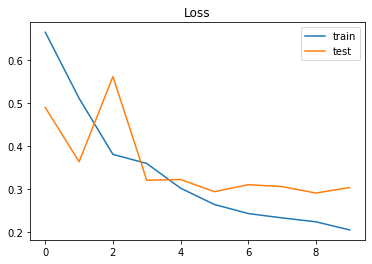

In [59]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

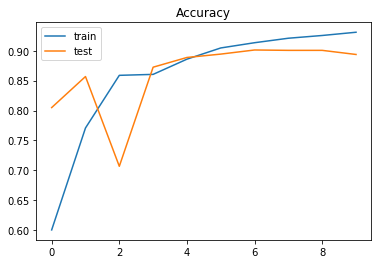

In [60]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

The plots suggest that the model has a little over fitting problem, more data may help, but more epochs will not help using the current data.

In [62]:
# Load the extension and start TensorBoard

# %load_ext tensorboard.notebook
# %tensorboard --logdir logs
# %reload_ext tensorboard.notebook

In [63]:
epoch_num = 3

model = model_init()

history = model.fit(train_X, train_y, epochs=epoch_num, batch_size=64, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), tensorboard_callback])

Train on 14400 samples, validate on 1600 samples
Epoch 1/3
14400/14400 [==============================] - 36s 3ms/step - loss: 0.6841 - acc: 0.5806 - val_loss: 0.6557 - val_acc: 0.6150
Epoch 2/3
14400/14400 [==============================] - 35s 2ms/step - loss: 0.6602 - acc: 0.6109 - val_loss: 0.6379 - val_acc: 0.6500
Epoch 3/3
14400/14400 [==============================] - 36s 3ms/step - loss: 0.6158 - acc: 0.6700 - val_loss: 0.3912 - val_acc: 0.8688


### Evaluate test set

In [65]:
# Final evaluation of the model
scores = model.evaluate(test_X, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.67%


In [66]:
prediction = model.predict(test_X)
labels = [1 if x == "1" else 0 for x in test_y]


In [67]:
precision_recall = precision_recall_curve(labels, prediction)
precision_recall = pd.DataFrame.from_records(precision_recall).T
precision_recall.columns = ['Precision', 'Recall', 'Thresholds']
precision_recall["f1_score"] = 2 * (precision_recall.Precision * precision_recall.Recall) / (precision_recall.Precision + precision_recall.Recall)

In [68]:
# Find best model by max. f1-score
print("Max f1-Score: %.2f%%" % (max(precision_recall["f1_score"])))


Max f1-Score: 0.91%


In [69]:
# Find threshold for precision 
with open("qc_contact_request_deletion_reason_thresholds.txt","w") as file_thresholds:
    precisions_thresholds = [0.8, 0.85, 0.9, 0.95] 
    for p in precisions_thresholds: 
        t = min(precision_recall[precision_recall['Precision']>p]["Thresholds"])
        msg = "Threshold with precision > %.2f%%: %.2f%%" % (p, t)
        print(msg)
        file_thresholds.write(msg)

Threshold with precision > 0.80%: 0.04%


39

Threshold with precision > 0.85%: 0.06%


39

Threshold with precision > 0.90%: 0.17%


39

Threshold with precision > 0.95%: 0.54%


39

In [70]:
# # print precision, recall, f1-score curve
# # precision_recall.iplot(x='Thresholds', xTitle='Decision Threshold',yTitle='Score', title='Precision/Recall Tradeoff')
# precision_recall.plot(x='Thresholds')

# Trace1 can be viewed like a geom_point() layer with various arguements
trace1 = go.Scatter(x=precision_recall.Thresholds, y = precision_recall.Precision,  marker=dict(size=5,
                line=dict(width=1),
                color="blue"
               ), 
                    mode="lines", name='Precision')
trace2 = go.Scatter(x=precision_recall.Thresholds, y = precision_recall.Recall,  marker=dict(size=5,
                line=dict(width=1),
                color="orange"
               ), 
                    mode="lines", name='Recall')

trace3 = go.Scatter(x=precision_recall.Thresholds, y = precision_recall.f1_score,  marker=dict(size=5,
                line=dict(width=1),
                color="green"
               ), 
                    mode="lines", name='f1_score')



data1 = go.Data([trace1, trace2, trace3])
layout1=go.Layout(title="Threshold vs P, R, F1", xaxis={'title':'Threshold'}, yaxis={'title':'Threshold Tradeoff'})
figure1=go.Figure(data=data1,layout=layout1)
iplot(figure1)

/Users/agnes.ferenczi/.pyenv/versions/3.6.7/envs/qc-contactrequest/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [71]:
predLabel = pd.DataFrame(prediction, columns = ["Probability"]).assign(Label=labels)
trace4 = go.Histogram(
    x=predLabel[predLabel.Label == 0].Probability,
    opacity=1,
    name = "1"
)
trace5 = go.Histogram(
    x=predLabel[predLabel.Label == 1].Probability,
    opacity=0.3,
    name = "0"
)

data45 = go.Data([trace4, trace5])
layout45 = go.Layout(barmode='overlay')
figure45 = go.Figure(data=data45, layout=layout45)

iplot(figure45, filename='probability overlaid histogram')


In [72]:
threshold = 0.9
y_true = [1 if x =="1" else 0 for x in test_y]
y_pred = [1 if x > threshold else 0 for x in prediction]
confusion_matrix(y_true, y_pred)


array([[1809,   36],
       [ 456, 1699]])

In [73]:
predictionDF = pd.DataFrame({'prediction':prediction[:,0]})
predicted_test = test.join(predictionDF, how='inner')
predicted_test['y_pred'] = predicted_test['prediction'].progress_apply(lambda x: 1 if x > threshold else 0)

100%|██████████| 4000/4000 [00:00<00:00, 447475.96it/s]


In [74]:
# false negatives
predicted_test[(predicted_test['y_pred'] == 0) & (predicted_test['target'] == '1')]


,label,decoded_title,decoded_body,question_text,target,prediction,y_pred
0,__label__contact-request,chemo . wer hat das geschaft ?,"hallo . möchte gerne wissen , wie ihr chemo geschaft habt ? . wie groß war tumor ? ohne op oder mit ? was habt ihr gemacht um wenniger schaden zu bekommen ? gerne e-mail , um persönlicher zu schreiben . ( schreibe zweites mall . die erste wurde nicht veröffentlicht ) danke .","chemo . wer hat das geschaft ? hallo . möchte gerne wissen , wie ihr chemo geschaft habt ? . wie groß war tumor ? ohne op oder mit ? was habt ihr gemacht um wenniger schaden zu bekommen ? gerne e-mail , um persönlicher zu schreiben . ( schreibe zweites mall . die erste wurde nicht veröffentlicht ) danke .",1,0.506466,0
16,__label__contact-request,"hallo , ich bin 25 und leide unter einem kleinen penis , was soll ich machen ?","ich habe noch kein sex mit einer frau gehabt , ich habe sowas von angst , ich weiß nicht was ich machen soll . . . . 🙁 <x-gf-img-placeholder data-image-id= "" 11806476 "" > </x-gf-img-placeholder>","hallo , ich bin 25 und leide unter einem kleinen penis , was soll ich machen ? ich habe noch kein sex mit einer frau gehabt , ich habe sowas von angst , ich weiß nicht was ich machen soll . . . . 🙁 <x-gf-img-placeholder data-image-id= "" 11806476 "" > </x-gf-img-placeholder>",1,0.058508,0
39,87976442,wie ist eure meinung zu anderen religionen ?,"hallo gutefrage comunity ich wollte mal fragen was ihr für eine meinung zu anderen religionen und deren feiertage , bräuche usw . habt . ich persönlich bin eigentlich christ aber hab mir über die jahre bisschen eigene gedanken über gott und alles gemacht als es das christentum vorschreibt . denn ich kann nicht glauben das etwas perfekt ist , was schon immer und heute noch zu vielen kriegen und toten führt . ich freue mich auf jede meinung , egal ob ich sie vertreten kann oder nicht , und bin zum diskutieren bereit😁","wie ist eure meinung zu anderen religionen ? hallo gutefrage comunity ich wollte mal fragen was ihr für eine meinung zu anderen religionen und deren feiertage , bräuche usw . habt . ich persönlich bin eigentlich christ aber hab mir über die jahre bisschen eigene gedanken über gott und alles gemacht als es das christentum vorschreibt . denn ich kann nicht glauben das etwas perfekt ist , was schon immer und heute noch zu vielen kriegen und toten führt . ich freue mich auf jede meinung , egal ob ich sie vertreten kann oder nicht , und bin zum diskutieren bereit😁",1,0.036431,0
40,__label__contact-request,guten tag schafft es einer von euch dieses schwarze gekritzelte weg zumachen und das man das wieder lesen kann der jenige der es schafft kriegt 50€ von mir ?,"<x-gf-img-placeholder data-image-id= "" 11623890 "" > </x-gf-img-placeholder>","guten tag schafft es einer von euch dieses schwarze gekritzelte weg zumachen und das man das wieder lesen kann der jenige der es schafft kriegt 50€ von mir ? <x-gf-img-placeholder data-image-id= "" 11623890 "" > </x-gf-img-placeholder>",1,0.039096,0
80,__label__contact-request,ich brauch einen partner für den schulball ?,,ich brauch einen partner für den schulball ?,1,0.883228,0
...,...,...,...,...,...,...,...
3963,__label__contact-request,wie komme ich schnellstmöglich an geld wichtig ?,"ich wollte mal fragen wie ich schnell an geld komme ? es geht darum ich bin 17 jahre kein kontakt zu meinen eltern , beziehungsweise selten . bin naja wie soll ich es sagen , ein bisschen dolle verschuldet und nun brauche ich geld . ja ich weiß einen kredit kriege ich noch nicht . . um ehrlich zu sein würde ich alles machen nur damit ich wenigstens die schulden los bin . wenn mir jemand einen rat geben kann wie ich schnell an geld komme , wäre das echt toll .","wie komme ich schnellstmöglich an geld wichtig ? ich wollte mal fragen wie ich schnell an geld komme ? es geht darum ich bin 17 jahre kein kontakt zu meinen eltern , beziehungsweise selten . bin naja wie soll ich es sagen , ein bisschen dolle verschuldet und nun brauche ich geld . 

In [75]:
# false positive
predicted_test[(predicted_test['y_pred'] == 1) & (predicted_test['target'] == '0')]

,label,decoded_title,decoded_body,question_text,target,prediction,y_pred
406,__label__legit,wer von euch trägt gerne pleaser ?,"würd mich nur mal sehr interessieren 😊 <x-gf-img-placeholder data-image-id= "" 12284167 "" > </x-gf-img-placeholder>","wer von euch trägt gerne pleaser ? würd mich nur mal sehr interessieren 😊 <x-gf-img-placeholder data-image-id= "" 12284167 "" > </x-gf-img-placeholder>",0,0.998856,1
421,__label__legit,kann man auf dem honor lite 20 pokemon go spielen oder nicht ?,honor lite 20,kann man auf dem honor lite 20 pokemon go spielen oder nicht ? honor lite 20,0,0.900314,1
455,__label__legit,"tinder , lovoo geeignet ?","hallo zusammen ! über mich : w , 14 , suche eine freundin , bin nicht wirklich romantisch und suche wie gesagt etwas festes , jemanden mit dem ich mir auch eine weitere zukunft ( zb hochzeit/kinder ) vorstellen kann . im alltag finde ich leider nicht viele "" gleichgesinnte "" die ebenfalls als mächchen auf mädchen stehen . da ich noch sehr jung bin und von datingapps meistens nur schlechtes höre weiß ich nicht ob ich mir eine installieren sollte . ist das für mich geeignet ?","tinder , lovoo geeignet ? hallo zusammen ! über mich : w , 14 , suche eine freundin , bin nicht wirklich romantisch und suche wie gesagt etwas festes , jemanden mit dem ich mir auch eine weitere zukunft ( zb hochzeit/kinder ) vorstellen kann . im alltag finde ich leider nicht viele "" gleichgesinnte "" die ebenfalls als mächchen auf mädchen stehen . da ich noch sehr jung bin und von datingapps meistens nur schlechtes höre weiß ich nicht ob ich mir eine installieren sollte . ist das für mich geeignet ?",0,0.990550,1
529,__label__legit,offenstall graz umgebung ?,"hallo ! ich bin auf der suche nach einem offenstall im umkreis von graz ( bis 30 km ) mit reitplatz und ausreitmöglichkeiten für max . 200€ im monat pro pferd - für 1 pferd und 1 pony . ich habe schon sehr viel online geschaut , aber die suche gestaltet sich schwierig . würde mich sehr über empfehlungen freuen ! liebe grüße","offenstall graz umgebung ? hallo ! ich bin auf der suche nach einem offenstall im umkreis von graz ( bis 30 km ) mit reitplatz und ausreitmöglichkeiten für max . 200€ im monat pro pferd - für 1 pferd und 1 pony . ich habe schon sehr viel online geschaut , aber die suche gestaltet sich schwierig . würde mich sehr über empfehlungen freuen ! liebe grüße",0,0.999178,1
604,__label__legit,pocket camp sachen verschenken ?,ich spiele jetzt schon ein paar tage animal crossing pocket camp und mir wurden sternis von einem online freund geschenkt und ich würde ihr auch gerne etwas zurück schenken jedoch weiß ich nicht wie man etwas verschenken kann . . c :,pocket camp sachen verschenken ? ich spiele jetzt schon ein paar tage animal crossing pocket camp und mir wurden sternis von einem online freund geschenkt und ich würde ihr auch gerne etwas zurück schenken jedoch weiß ich nicht wie man etwas verschenken kann . . c :,0,0.999156,1
629,__label__legit,gute leistungen bundesjugendspiele ?,hallo ich bin 14 männlich und möchte wissen ob meine leistung gut sind : 100 m sprint : 13_2 sec 800 m sprint : 2_35 min spung : 5_40 m ballwurf : 70 m,gute leistungen bundesjugendspiele ? hallo ich bin 14 männlich und möchte wissen ob meine leistung gut sind : 100 m sprint : 13_2 sec 800 m sprint : 2_35 min spung : 5_40 m ballwurf : 70 m,0,0.991699,1
674,__label__legit,soll ich sie so über snapchat nach einem treffen fragen ?,"sie 17 ich 18 , kennen uns nicht persönlich , hatte vor sie wie folgt nach einem treffen zu fragen : also ich finde dich echt sympathisch und hübsch und ich möchte dich fragen ob wir uns mal treffen wollen ? habt ihr andere ideen oder so , möchte nichts falsch machen 2 . —> was sollen wir machen , bzw . wo sollen wir uns treffen , soll ich das vorschlagen oder sie zuerst fragen ? danke für eure antworten","soll ich sie so über snapchat nach einem treffen fragen ? sie 17 ich 18 , kennen uns nicht persönlich , hatte vor sie wie folgt nach einem tref

### Evaluate on sample from "allquestion" dataset

### Train model on all data

In [33]:
# concatenate positive and negative samples
data = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)

data['question_text'] = data['decoded_title'].map(str) + " " + data['decoded_body'].map(str)

## fill up the missing values
data_X = data["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='', lower=False)
tokenizer.fit_on_texts(list(data_X))
data_X = tokenizer.texts_to_sequences(data_X)

## Pad the sentences 
data_X = pad_sequences(data_X, maxlen=maxlen, padding='post', truncating='post')

data["target"] = ["0" if x =="__label__legit" else "1" for x in data["label"]]

data_y = data['target']


In [34]:
# save tokenizer for model
with open('qc_contact_request_deletion_reason_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('qc_contact_request_deletion_reason_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())    


27344966

In [35]:
model = model_init()

model.fit(data_X, data_y, epochs=epoch_num, batch_size=64, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save model
modelfile = "qc_contact_request_deletion_reason_model.h5"
model.save(modelfile)

Train on 97666 samples, validate on 10852 samples
Epoch 1/3
97666/97666 [==============================] - 269s 3ms/step - loss: 0.2322 - acc: 0.9307 - val_loss: 0.1097 - val_acc: 0.9652
Epoch 2/3
97666/97666 [==============================] - 275s 3ms/step - loss: 0.1049 - acc: 0.9667 - val_loss: 0.0956 - val_acc: 0.9709
Epoch 3/3
97666/97666 [==============================] - 286s 3ms/step - loss: 0.0839 - acc: 0.9735 - val_loss: 0.0816 - val_acc: 0.9745


In [36]:
import os
import platform
import subprocess


def res_cmd(cmd):
  return str(subprocess.Popen(cmd, stdout=subprocess.PIPE,shell=True).communicate()[0])

def str_md5sum(abspath_file):
    str_res = res_cmd('md5sum "%s"' % abspath_file)
    return str_res.split("'")[1].replace('\\n', '')

print(str_md5sum(modelfile))   

69229e3eec7ae957128df4d2fc0c88e9  qc_contact_request_deletion_reason_model.h5
